In [1]:
import numpy as np

import matplotlib.pyplot as plt

import astropy
import astropy.wcs as wcs
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy.io import ascii, fits
from astropy.table import Table
from astropy import units as u

from scipy.signal import convolve2d

from random import *

import func

import xidplus
from xidplus import moc_routines
import xidplus.catalogue as cat
import pickle

In [2]:
import numpy as np
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy import units as u

from xidplus import moc_routines
import pymoc
from pymoc.util import catalog

class prior(object):
    def cut_down_map(self):
        """Cuts down prior class variables associated with the map data to the MOC assigned to the prior class: self.moc
        """
        wcs_temp = wcs.WCS(self.imhdu)
        #print('wcs_temp: ', wcs_temp)
        
        #print(self.sx_pix)
        ra, dec = wcs_temp.wcs_pix2world(self.sx_pix, self.sy_pix, 0)
        print('ra, dec: ', ra, dec)
        
        ind_map = np.array(moc_routines.check_in_moc(ra, dec, self.moc))
        ##print('indmap: ', ind_map)
        
        
        # now cut down and flatten maps (default is to use all pixels, running segment will change the values below to pixels within segment)
        self.sx_pix = self.sx_pix[ind_map]
        ##print('self.sx_pix: ', self.sx_pix)
        
        self.sy_pix = self.sy_pix[ind_map]
        #print('self.sy_pix: ', self.sy_pix)
        
        self.snim = self.snim[ind_map]
        #print('self.snim: ', self.snim)
        
        self.sim = self.sim[ind_map]
        #print('self.sim: ', self.sim)
        
        self.snpix = sum(ind_map)
        #print('self.snpix: ', self.snpix)

        
    def cut_down_cat(self):
        """Cuts down prior class variables associated with the catalogue data to the MOC assigned to the prior class: self.moc
        """
        
        sgood = np.array(moc_routines.check_in_moc(self.sra, self.sdec, self.moc))

        self.sx = self.sx[sgood]
        #print('self.sx: ', self.sx)
        
        self.sy = self.sy[sgood]
        #print('self.sy: ', self.sy)
        
        self.sra = self.sra[sgood]
        #print('self.sra: ', self.sra)
        
        self.sdec = self.sdec[sgood]
        #print('self.sdec: ', self.sdec)
        
        self.nsrc = sum(sgood)
        #print('self.nsrc: ', self.nsrc)
        
        self.ID = self.ID[sgood]
        #print('self.ID: ', self.ID)
        
        
        if hasattr(self, 'nstack'):
            self.stack = self.stack[sgood]
            self.nstack = sum(self.stack)
            
        if hasattr(self, 'prior_flux_upper'):
            self.prior_flux_upper = self.prior_flux_upper[sgood]
            
        if hasattr(self, 'prior_flux_lower'):
            self.prior_flux_lower = self.prior_flux_lower[sgood]
        
        if hasattr(self,'z_median'):
            self.z_median=self.z_median[sgood]
            self.z_sig=self.z_sig[sgood]

    def cut_down_prior(self):

        """
        Cuts down prior class variables to the MOC assigned to the prior class
        """
        self.cut_down_map()
        self.cut_down_cat()

    def __init__(self, im, nim, imphdu, imhdu, moc=None):

        # ---for any bad pixels set map pixel to zero and uncertianty to 1----
        """Initiate prior class

        :param im: image map from fits file
        :param nim: noise map from fits file
        :param imphdu: Primary header associated with fits file
        :param imhdu: header associated with image map
        :param moc: (default=None) Multi-Order Coverage map of area being fit
        """
        bad = np.logical_or(np.logical_or
                            (np.invert(np.isfinite(im)),
                             np.invert(np.isfinite(nim))), (nim == 0))
        if (bad.sum() > 0):
            im[bad] = 0.
            nim[bad] = 1.
        self.imhdu = imhdu
        wcs_temp = wcs.WCS(self.imhdu)
        self.imphdu = imphdu
        self.imhdu = imhdu

        x_pix, y_pix = np.meshgrid(np.arange(0, wcs_temp._naxis1), np.arange(0, wcs_temp._naxis2))
        #x_pix, y_pix = np.meshgrid(np.arange(0, len(im),1.0), np.arange(0, len(im),1.0))
        
        self.sx_pix = x_pix.flatten()
        print(self.sx_pix)
        self.sy_pix = y_pix.flatten()
        
        self.snim = nim.flatten()
        
        self.sim = im.flatten()
        
        self.snpix = self.sim.size
        
        
        if moc is not None:
            self.moc = moc
            self.cut_down_map()

    def prior_bkg(self, mu, sigma):
        r"""Add background prior. Assumes :math:`B \sim \mathcal{N}(\mu,\sigma^2)`

        :param mu: mean
        :param sigma: standard deviation
        """

        self.bkg = (mu, sigma)

    def prior_cat(self, ra, dec, prior_cat_file, flux_lower=None, flux_upper=None, ID=None, moc=None,z_median=None,z_sig=None):
        """Input info for prior catalogue

        :param ra: Right ascension (JD2000) of sources
        :param dec: Declination (JD2000) of sources
        :param prior_cat_file: filename of catalogue
        :param flux_lower: lower limit of flux for each source
        :param flux_upper: upper limit of flux for each source
        :param ID: HELP_ID for each source
        :param moc: Multi-Order Coverage map
        :param z_median: median of redshift pdf
        :param z_sig: sigma of redshift pdf
        """
        # get positions of sources in terms of pixels
        wcs_temp = wcs.WCS(self.imhdu)
        sx, sy = wcs_temp.wcs_world2pix(ra, dec, 0)
        #print(ra,dec)
        if moc is None:
            cat_moc = moc_routines.create_MOC_from_cat(ra, dec)
            c = SkyCoord(ra*u.degree,dec*u.degree)
            moc=pymoc.util.catalog.catalog_to_moc(c,60,15)
            #print('cat_moc: ', cat_moc)
        else:
            cat_moc = moc
            
            
        #print('')
        # Redefine prior list so it only contains sources in the map
        self.sx = sx
        #print('sx: ', sx)
        
        self.sy = sy
        #print('sy: ', sy)
        
        self.sra = ra
        #print('self.sra: ', self.sra)
        
        self.sdec = dec
        #print('dec: ', dec)
        
        self.nsrc = self.sra.size
        #print('self.nsrc: ', str(self.nsrc))
        
        self.prior_cat = prior_cat_file
        #print('self.prior_cat: ', self.prior_cat)
        
        
        if flux_lower is None:
            flux_lower = np.full((ra.size), 0.00)
            flux_upper = np.full((ra.size), 1000.0)
        
        self.prior_flux_lower = flux_lower
        #print(flux_lower)
        self.prior_flux_upper = flux_upper
        #print(flux_upper)
        
        
        if z_median is not None:
            self.z_median=z_median
            self.z_sig=z_sig

        if ID is None:
            ID = np.arange(1, ra.size + 1, dtype='int64')
        self.ID = ID
        #print(ID)
        

        self.stack = np.full(self.nsrc, False)
        #print(self.stack)
        
        
        try:
            self.moc = self.moc.intersection(cat_moc)
        
        except AttributeError as e:
            self.moc=cat_moc
        
        
        #print('')
        self.cut_down_prior()

    def set_tile(self, moc):
        """ Update prior with new MOC and update appropriate variables
        :param moc: Multi-order Coverage map from pymoc
        """
        self.moc = self.moc.intersection(moc)
        self.cut_down_prior()

    def prior_cat_stack(self, ra, dec, prior_cat, flux_lower=None, flux_upper=None,ID=None):
        """Input info for prior catalogue of sources being stacked

        :param ra: Right ascension (JD2000) of sources
        :param dec: Declination (JD2000) of sources
        :param prior_cat: filename of catalogue
        :param ID: HELP_ID for each source
        """
        wcs_temp = wcs.WCS(self.imhdu)
        sx, sy = wcs_temp.wcs_world2pix(ra, dec, 0)


        # Redefine prior list so it only contains sources in the map

        # Redefine prior list so it only contains sources in the map
        self.sx = np.append(self.sx, sx)
        
        self.sy = np.append(self.sy, sy)
        
        self.sra = np.append(self.sra, ra)
        
        self.sdec = np.append(self.sdec, dec)
        
        self.nstack = ra.size
        
        self.nsrc = self.sra.size
        
        self.stack = np.append(self.stack, np.full((self.nstack), True))
        
        
        if ID is None:
            ID = np.arange(1, ra.size + 1, dtype='int64')
            
        self.ID = np.append(self.ID, ID)
        
        
        if flux_lower is None:
            flux_lower = np.full((ra.size), 0.00)
            flux_upper = np.full((ra.size), 1000.0)
            self.prior_flux_lower = np.append(self.prior_flux_lower,flux_lower)
            self.prior_flux_upper = np.append(self.prior_flux_upper,flux_upper)

        self.cut_down_prior()

        
    def set_prf(self, prf, pindx, pindy):
        """Add prf array and corresponding x and y scales (in terms of pixels in map)

        :param prf: n x n array, where n is an odd number, and the centre of the prf is at the centre of the array
        :param pindx: n array, pixel scale of prf array
        :param pindy: n array, pixel scale of prf array
        """

        self.prf = prf
        
        self.pindx = pindx
        
        self.pindy = pindy


    def get_pointing_matrix_coo(self):
        """Get scipy coo version of pointing matrix. Useful for sparse matrix multiplication"""
        from scipy.sparse import coo_matrix
        self.A = coo_matrix((self.amat_data, (self.amat_row, self.amat_col)), shape=(self.snpix, self.nsrc))



    def upper_lim_map(self):
        """Update flux upper limit to abs(bkg)+2*sigma_bkg+max(D)
         where max(D) is maximum value of pixels the source contributes to"""

        self.prior_flux_upper = np.full((self.nsrc), 1000.0)
        for i in range(0, self.nsrc):
            ind = self.amat_col == i
            if ind.sum() > 0:
                self.prior_flux_upper[i] = np.max(self.sim[self.amat_row[ind]]) + (np.abs(self.bkg[0]) + 2 * self.bkg[1])

    def get_pointing_matrix_unknown_psf(self, bkg=True):
        """Calculate pointing matrix for unknown psf. If bkg = True, bkg is fitted to all pixels. If False, bkg only fitted to where prior sources contribute
        """
        from scipy import interpolate
        paxis1, paxis2 = self.prf.shape

        amat_row = np.array([], dtype=int)
        
        amat_col = np.array([], dtype=int)
        
        amat_data = np.array([])
        

        # ------Deal with PRF array----------
        centre = ((paxis1 - 1) / 2)
        
        # create pointing array
        for s in range(0, self.nsrc):

            # diff from centre of beam for each pixel in x
            dx =  self.sx_pix-self.sx[s]
            
            # diff from centre of beam for each pixel in y
            dy =  self.sy_pix -self.sy[s]
            
            # diff from each pixel in prf
            pindx = self.pindx - (paxis1 - 1.) / 2. + self.sx[s] - np.rint(self.sx[s]).astype(np.long)
            pindy = self.pindy + self.sy[s] - np.rint(self.sy[s]).astype(np.long)
            
            # diff from pixel centre
            px = self.sx[s] - np.rint(self.sx[s]).astype(np.long) + (paxis1 - 1.) / 2.
            py = self.sy[s] - np.rint(self.sy[s]).astype(np.long) + (paxis2 - 1.) / 2.

            dist=np.sqrt(dx**2+dy**2)
            good = dist < self.pindx[-1]/2.0
            ngood = good.sum()
            bad = np.asarray(good) == False
            nbad = bad.sum()
            
            
            if ngood > 0.5 * self.pindx[-1] * self.pindy[-1]:
                f = interpolate.interp1d(self.pindx[0:(paxis1 + 1.) / 2],np.arange((paxis1 + 1.) / 2.),kind='nearest')
                atemp=f(dist[good])
                amat_data = np.append(amat_data, atemp)
                amat_row = np.append(amat_row,
                                     np.arange(0, self.snpix, dtype=int)[good])  # what pixels the source contributes to
                amat_col = np.append(amat_col, np.full(ngood, s))  # what source we are on

        
        self.amat_data = amat_data
        self.amat_row = amat_row
        self.amat_col = amat_col
        

    def get_pointing_matrix(self, bkg=True):
        """Calculate pointing matrix. If bkg = True, bkg is fitted to all pixels. If False, bkg only fitted to where prior sources contribute
        """
        from scipy import interpolate
        paxis1, paxis2 = self.prf.shape

        amat_row = np.array([], dtype=int)
        amat_col = np.array([], dtype=int)
        amat_data = np.array([])

        # ------Deal with PRF array----------
        centre = ((paxis1 - 1) / 2)
        # create pointing array
        for s in range(0, self.nsrc):

            # diff from centre of beam for each pixel in x
            dx = -np.rint(self.sx[s]).astype(np.long) + self.pindx[np.rint((paxis1 - 1.) / 2).astype(np.long)] + self.sx_pix
            # diff from centre of beam for each pixel in y
            dy = -np.rint(self.sy[s]).astype(np.long) + self.pindy[np.rint((paxis2 - 1.) / 2).astype(np.long)] + self.sy_pix

            # diff from each pixel in prf
            pindx = self.pindx + self.sx[s] - np.rint(self.sx[s]).astype(np.long)
            pindy = self.pindy + self.sy[s] - np.rint(self.sy[s]).astype(np.long)


            good = (dx >= 0) & (dx < self.pindx[paxis1 - 1]) & (dy >= 0) & (dy < self.pindy[paxis2 - 1])
            ngood = good.sum()
            bad = np.asarray(good) == False
            nbad = bad.sum()
            ipx2, ipy2 = np.meshgrid(pindx, pindy)
            atemp = interpolate.griddata((ipx2.ravel(), ipy2.ravel()), self.prf.ravel(), (dx[good], dy[good]),
                                             method='nearest')

            if atemp.size > 0:
                keep=atemp > np.max(atemp)/1.0E3
                amat_data = np.append(amat_data, atemp[keep])
                amat_row = np.append(amat_row,np.arange(0, self.snpix, dtype=int)[good][keep])  # what pixels the source contributes to
                amat_col = np.append(amat_col, np.full(keep.sum(), s))  # what source we are on


        self.amat_data = amat_data
        self.amat_row = amat_row
        self.amat_col = amat_col


In [3]:
def gauss_1(x,s):
    return np.exp(-x**2/(2*s**2))

In [4]:
def data_map_250(seperation, flux_ratio, snr):
    
    sim_length = 60 #box length of the simulated data in arcseconds
    pixsize = 6
    dat_map = np.zeros((sim_length,sim_length))
    
    t = np.arange(-36, 37, 1)
    gaus = gauss_1(t,18.15/2.355) #create gaussian beam for SPIRE at 250um
    g = gaus[:, np.newaxis] * gaus[np.newaxis, :]
    
    y1 = 10
    y2 = y1*flux_ratio 
    
    dat_map[int(sim_length/2-seperation/2),int(sim_length/2)]=y1
    dat_map[int(sim_length/2+seperation/2),int(sim_length/2)]=y2
    plt.imshow(dat_map)
    x = [int(sim_length/2),int(sim_length/2)]
    y = [int(sim_length/2-seperation/2),int(sim_length/2+seperation/2)]
    plt.scatter(x,y,s=1,c='blue')
    plt.show()
    
    dat_conv = convolve2d(dat_map, g, mode='same')
    plt.imshow(dat_conv)
    x = [int(sim_length/2),int(sim_length/2)]
    y = [int(sim_length/2-seperation/2),int(sim_length/2+seperation/2)]
    plt.scatter(x,y,s=1,c='black')
    plt.show()
        
    final_map = np.zeros((int(sim_length/pixsize),int(sim_length/pixsize)))
        
    n = 0
    m = 0
        
        
    for n in range(len(final_map)):
        for m in range(len(final_map)):
            #print(dat_conv[pixsize*n:pixsize*n+pixsize-1,pixsize*m:pixsize*m+pixsize-1])
            #print(np.mean(dat_conv[pixsize*n:pixsize*n+pixsize-1,pixsize*m:pixsize*m+pixsize-1]))
            final_map[n,m] = np.mean(dat_conv[pixsize*n:pixsize*n+pixsize-1,pixsize*m:pixsize*m+pixsize-1])
    
    plt.imshow(final_map)
    x_pos = np.array([sim_length/2*1/pixsize-2.5/pixsize,sim_length/2/pixsize-2.5/pixsize])
    y_pos = np.array([(sim_length/2-seperation/2)/pixsize-2.5/pixsize,(sim_length/2+seperation/2)/pixsize-2.5/pixsize])
    print(x_pos)
    print(y_pos)
    plt.scatter(x_pos,y_pos,s=1,c='black')
    plt.show()
    noise = abs(np.random.normal(0, y1/snr, int(sim_length/pixsize)**2).reshape(int(sim_length/pixsize),int(sim_length/pixsize)))
        
    f_n_map = final_map+noise
        
        #a = np.ones((sim_length/pixsize,sim_length/pixsize))
    hdu1 = fits.PrimaryHDU()
    hdu2 = fits.ImageHDU(f_n_map)
    hdu3 = fits.ImageHDU(noise)    
    
    hdulist = fits.HDUList([hdu1, hdu2, hdu3])
        
    image_file = fits.open('../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/COSMOS_SPIRE250_v1.0.fits')
    imphdu=image_file[0].header
    imhdu=image_file[1].header
    image = image_file[1].data
    image_error = image_file[3].data
    wcs_h =  (wcs.WCS(image_file[1].header)).celestial
    image_file.close()
        
    ra = 150.
    dec = 2.
    pix_y,pix_x = wcs_h.wcs_world2pix(ra,dec,0)
    offset_ra_pix = (x_pos - np.round(x_pos,0))/3600*pixsize
    offset_dec_pix= (y_pos - np.round(y_pos,0))/3600*pixsize
    
    ra_cent,dec_cent = wcs_h.wcs_pix2world(np.round(pix_y,0),np.round(pix_x,0),0)
    print(ra_cent,dec_cent)
    offset_ra_grid = 150-ra_cent
    offset_dec_grid= 2-dec_cent
    print(offset_ra_grid*3600,offset_dec_grid*3600)

    inra = ra-offset_ra_pix-offset_ra_grid
    indec = np.array([dec-seperation/3600/2,dec+seperation/3600/2])

    indec = indec + offset_dec_pix - offset_dec_grid

    prior_cat = [inra,indec]
    print(prior_cat)
    c = SkyCoord(ra*u.degree,dec*u.degree)
    
    print(wcs_h.wcs_world2pix(inra,indec,0))
        
    xmin = int(pix_x-(len(f_n_map))/2)+1
    xmax = int(pix_x+(len(f_n_map))/2)+1
    ymin = int(pix_y-(len(f_n_map))/2)+1
    ymax = int(pix_y+(len(f_n_map))/2)+1
    print(xmin,xmax,ymin,ymax)
    image[xmin:xmax,ymin:ymax] = f_n_map
    image_error[xmin:xmax,ymin:ymax] = noise
    return(image,prior_cat,wcs_h,image_error,c,imphdu,imhdu)

In [5]:
def data_map_350_wcs(seperation, flux_ratio, snr):
    
    sim_length = 120 #box length of the simulated data in arcseconds
    pixsize = 8.33
    dat_map = np.zeros((sim_length,sim_length))
    
    t = np.arange(-50, 50, 1)
    gaus = gauss_1(t,25.15/2.355) #create gaussian beam for SPIRE at 250um
    g = gaus[:, np.newaxis] * gaus[np.newaxis, :]
    
    y1 = 10
    y2 = y1*flux_ratio 
    
    dat_map[int(sim_length/2-seperation/2),int(sim_length/2)]=y1
    dat_map[int(sim_length/2+seperation/2),int(sim_length/2)]=y2
    x = np.array([int(sim_length/2),int(sim_length/2)])
    y = np.array([int(sim_length/2-seperation/2),int(sim_length/2+seperation/2)])

    
    dat_conv = convolve2d(dat_map, g, mode='same')
    
    #create a wcs for the high resolution map
    w_high_res = wcs.WCS(naxis=2)
    #assign coordinates to the bottom left hand corner of the data
    w_high_res.wcs.crval = [150.,2.]
    w_high_res.wcs.crpix = [-0.5,-0.5]
    w_high_res.wcs.cdelt = [1/3600,1/3600]
    print('coordinates of -0.5,-0.5 is: {}'.format(w_high_res.wcs_pix2world(-0.5,-0.5,1)))
    #convert the pixel coordinates of the sources to ra and dec
    #the last parameter should be 1 because it is a fits file. 
    #i'm not so sure about the reason it is a one but that is what it should be
    source_ra,source_dec = w_high_res.wcs_pix2world(x,y,1)
    print('value at source location is: {}'.format(dat_conv[y,x]))
    print(source_ra,source_dec*3600)
    source_x_coord,source_y_coord = w_high_res.wcs_world2pix(source_ra,source_dec,1)
    print(source_x_coord,source_y_coord)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=w_high_res)
    ax.imshow(dat_conv, interpolation='nearest', origin='lower')
    x_test,y_test = w_high_res.wcs_pix2world(-0.5,-0.5,0)
    ax.scatter(x_test,y_test,transform=ax.get_transform('world'),c='green',s=5)
    ax.scatter(150.,2.,transform=ax.get_transform('world'),c='green',s=5)
    ax.scatter(source_ra,source_dec,transform=ax.get_transform('world'),c='blue',s=1)
    #plt.xlim(-1.5,1.5)
    #plt.ylim(-1.5,1.5)
    plt.show()
        
    final_map = np.zeros((int(sim_length/pixsize),int(sim_length/pixsize)))

    #create a low resolution             
    for n in range(len(final_map)):
        for m in range(len(final_map)):
            #print(dat_conv[pixsize*n:pixsize*n+pixsize-1,pixsize*m:pixsize*m+pixsize-1])
            #print(np.mean(dat_conv[pixsize*n:pixsize*n+pixsize-1,pixsize*m:pixsize*m+pixsize-1]))
            final_map[n,m] = np.mean(dat_conv[pixsize*n:pixsize*n+pixsize-1,pixsize*m:pixsize*m+pixsize-1])
    
    noise = abs(np.random.normal(0, y1/snr, int(sim_length/pixsize)**2).reshape(int(sim_length/pixsize),int(sim_length/pixsize)))
        
    f_n_map = final_map+noise
        
    #create a fits file with the low resolution map and the noise map
    hdu1 = fits.PrimaryHDU()
    hdu2 = fits.ImageHDU(f_n_map)
    hdu3 = fits.ImageHDU(noise)    
    
    hdulist = fits.HDUList([hdu1, hdu2, hdu3])
    
    #create a wcs for the low resolution map
    w_low_res = wcs.WCS(naxis=2)
    w_low_res.wcs.ctype = ['RA---TAN','DEC--TAN']
    w_low_res.wcs.crval = [150.,2.]
    w_low_res.wcs.crpix = [-0.5,-0.5]
    w_low_res.wcs.cdelt = [pixsize/3600,pixsize/3600]
    w_low_res.pixel_shape = [len(f_n_map),len(f_n_map)]
    print(w_high_res.wcs_world2pix(150.,2.,1))
    print(w_low_res.wcs_world2pix(150.,2.,1))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=w_low_res)
    ax.imshow(f_n_map, interpolation='nearest', origin='lower')
    ax.scatter(150.,2.,transform=ax.get_transform('world'),c='blue',s=1)
    ax.scatter(source_ra,source_dec,transform=ax.get_transform('world'),c='blue',s=1)
    plt.show()
    
    c = SkyCoord(np.mean(source_ra)*u.degree,np.mean(source_dec*u.degree))
    print(c)
    
    #create the header that xid+ will use to create it's own wcs
    hdu2.header['CTYPE1'] = 'RA---TAN'
    hdu2.header['CTYPE2'] = 'DEC--TAN'
    hdu2.header['CRVAL1'] = 150.
    hdu2.header['CRVAL2'] = 2.
    #These need to be 0.5 instead of -0.5 for some reason that i don't understand
    hdu2.header['CRPIX1'] = 0.5
    hdu2.header['CRPIX2'] = 0.5
    hdu2.header['CD1_1'] = pixsize/3600
    hdu2.header['CD1_2'] = 0.
    hdu2.header['CD2_1'] = 0.
    hdu2.header['CD2_2'] = pixsize/3600
    hdu2.header['NAXIS1'] = len(f_n_map)
    hdu2.header['NAXIS2'] = len(f_n_map)
    imhdu = ''
    
    return(f_n_map,[source_ra,source_dec],w_low_res,noise,c,hdu1,hdu2.header)

In [71]:
im250, prior_cat, w_250, nim250, c, im250phdu, im250hdu = func.data_map_250_wcs(24, 1, 120)

im350, prior_ca, w_350, nim350, c1, im350phdu, im350hdu = func.data_map_350(24, 1, 100)

im500, prior_ca, w_500, nim500, c1, im500phdu, im500hdu = func.data_map_500(24, 1, 100)

514 529 636 651
355 370 440 455


In [84]:
#need to add +0.5 to the ra. can't remeber why but it probably to do with the different way that fits and wcs 
#define the origin and to deal with the difference between the centre and edge of a pixel
inra = np.array(prior_cat[0])+0.5/3600
indec = np.array(prior_cat[1])

[ 150.01680556  150.01680556]


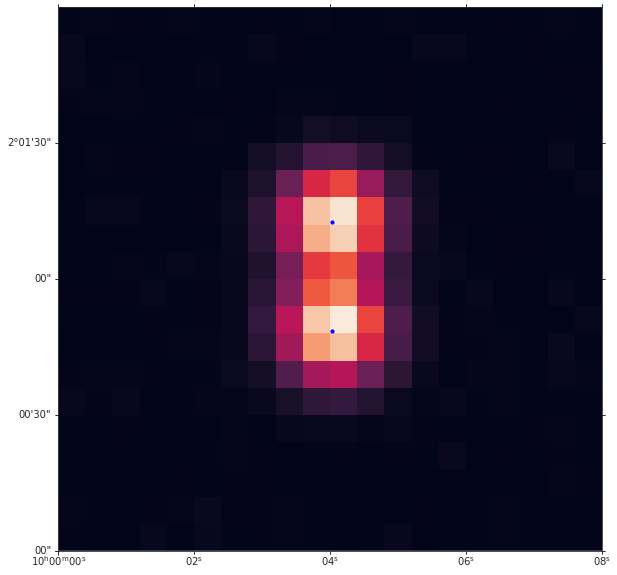

In [73]:
box_length = 1/30
w_test = wcs.WCS(im250hdu)
imgcut = Cutout2D(im250, c, size=[box_length*u.degree, box_length*u.degree], wcs=w_test)
wcscut = imgcut.wcs
imgcut = imgcut.data
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection=wcscut)
ax.imshow(imgcut, interpolation='nearest', origin='lower')
print(inra)
ax.scatter(inra,indec,transform=ax.get_transform('world'),c='blue',s=10)
#ax.scatter(150,2,transform=ax.get_transform('world'),c='blue',s=10)
#ax.scatter(149.99998402909674,2.000118264327631,transform=ax.get_transform('world'),c='green',s=100)
#plt.ylim(2.5,3.5)
#plt.xlim(4.5,5.5)
plt.show()

In [34]:

output_folder = './'


In [74]:
import pymoc
from pymoc.util import catalog
moc=pymoc.util.catalog.catalog_to_moc(c,120,15)

In [85]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu,moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(inra,indec,'test')#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu,moc=moc)
prior350.prior_cat(inra,indec,'test')
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu,moc=moc)
prior500.prior_cat(inra,indec,'test')
prior500.prior_bkg(-5.0,5)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



In [86]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([6, 10, 14])

#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])

#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel


##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')

prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')

prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires PRF as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [87]:
print('fitting '+ str(prior250.nsrc)+' sources \n')
print('using ' +  str(prior250.snpix)+', '+ str(prior350.snpix)+' and '+ str(prior500.snpix)+' pixels')

fitting 2 sources 

using 223, 152 and 73 pixels


In [88]:
prior250.get_pointing_matrix()

prior350.get_pointing_matrix()

prior500.get_pointing_matrix()

In [89]:
prior250.upper_lim_map()

prior350.upper_lim_map()

prior500.upper_lim_map()

In [90]:
from xidplus.stan_fit import SPIRE
fit=SPIRE.all_bands(prior250, prior350, prior500, iter=1000)

/mnt/pact/im281/FIR-group/Ian/xidplus_sim/XID+SPIRE.pkl
/XID+SPIRE found. Reusing


In [91]:
posterior=xidplus.posterior_stan(fit,[prior250,prior350,prior500])
priors = [prior250,prior350,prior500]

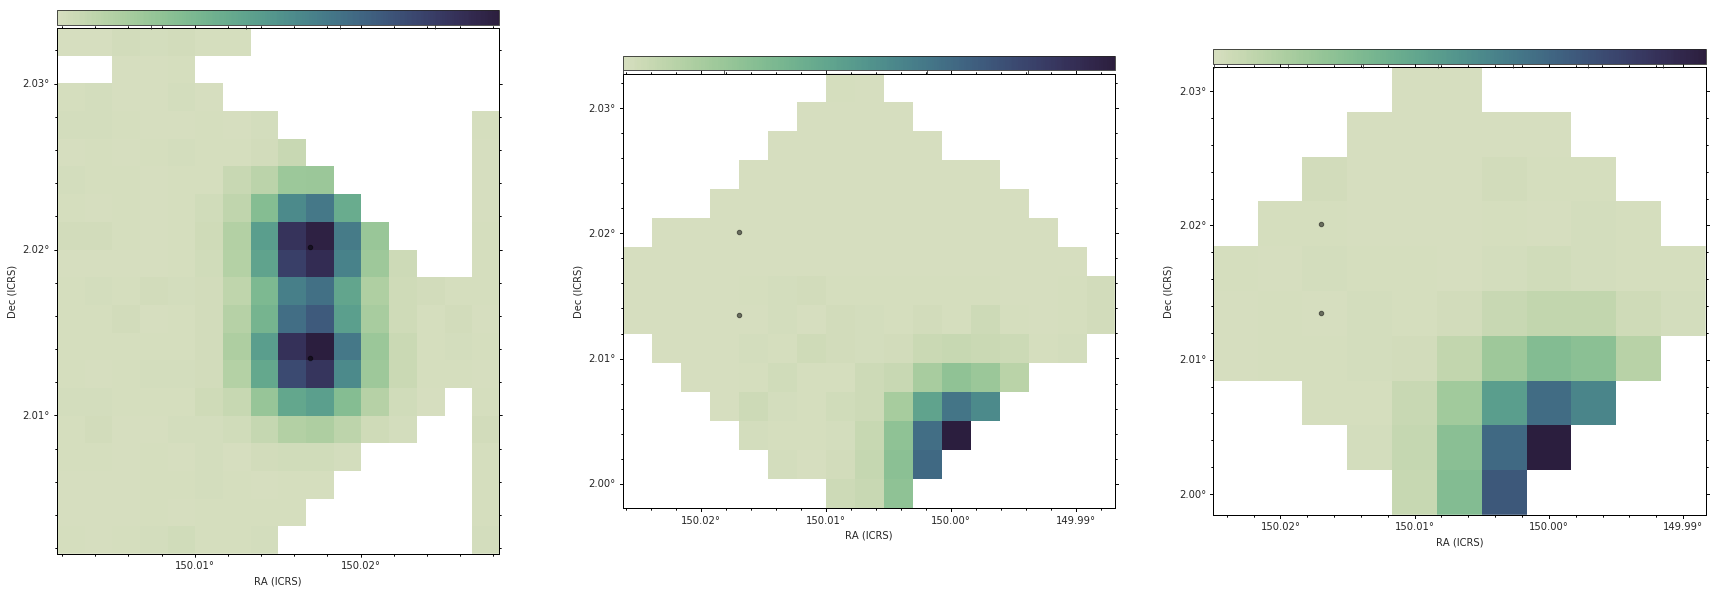

In [92]:
figs,fig=xidplus.plot_map(priors)

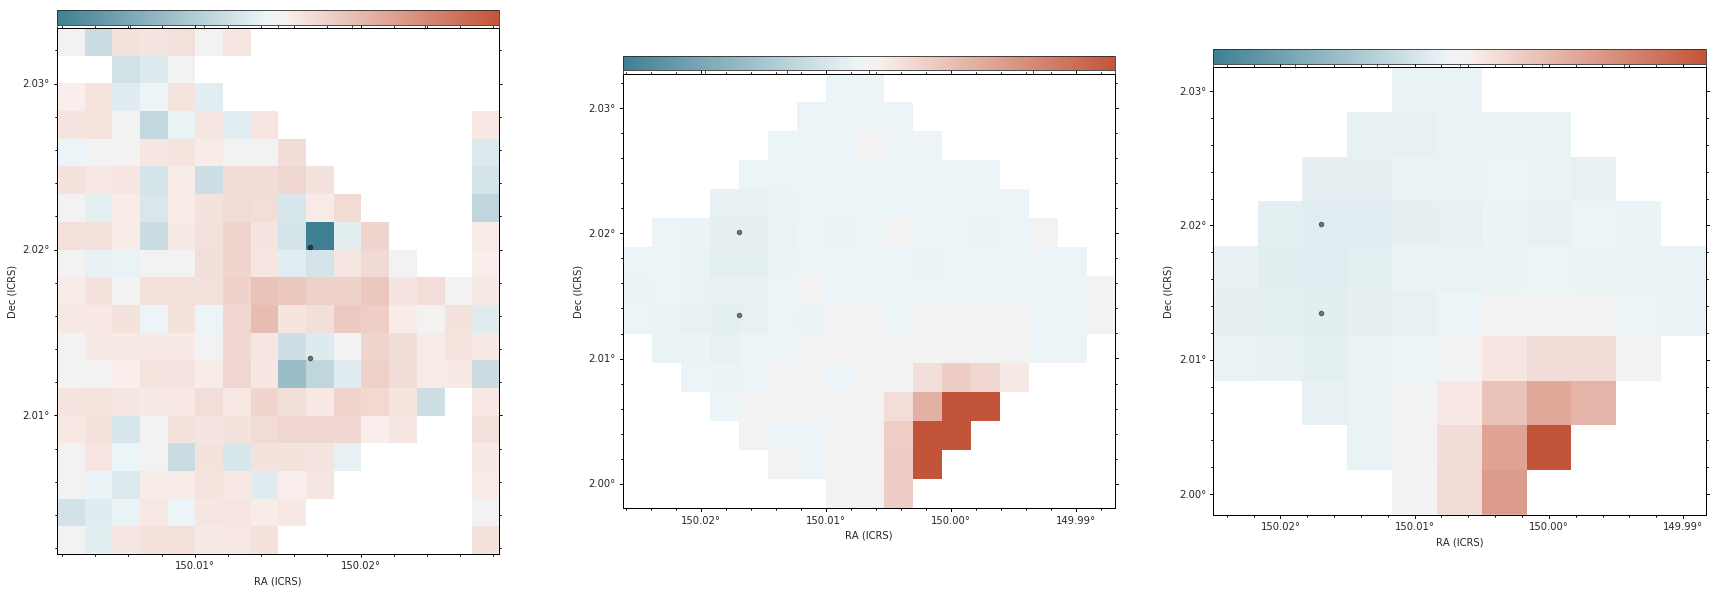

In [93]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)

In [69]:
SPIRE_cat=cat.create_SPIRE_cat(posterior,priors[0],priors[1],priors[2])

In [70]:
SPIRE_cat[1].data

FITS_rec([ ('1',  150.01694444,  2.01361111,  9.84175873,  9.86571789,  9.81777573,  0.28264642,  0.64255083,  0.08400133,  0.451455  ,  1.18997824,  0.10505115,  0.04282694,  0.37178218,  1.06688213,  0.02820262,  1.34199715,  2.63586473,  0.99886185,  1.00037789,  1.00027704,  3318.59667969,  1928.39733887,  2232.69628906,  1.,  1.,  1.),
          ('2',  150.01694444,  2.02027778,  9.8295393 ,  9.85217094,  9.80519581,  0.28900677,  0.68186933,  0.0722297 ,  0.48922911,  1.20248497,  0.13424361,  0.04282694,  0.37178218,  1.06688213,  0.02820262,  1.34199715,  2.63586473,  1.00004554,  0.99984014,  0.99965096,  2971.70068359,  2272.93359375,  1544.73974609,  1.,  1.,  1.)],
         dtype=(numpy.record, [('HELP_ID', 'S27'), ('RA', '<f8'), ('Dec', '<f8'), ('F_SPIRE_250', '<f4'), ('FErr_SPIRE_250_u', '<f4'), ('FErr_SPIRE_250_l', '<f4'), ('F_SPIRE_350', '<f4'), ('FErr_SPIRE_350_u', '<f4'), ('FErr_SPIRE_350_l', '<f4'), ('F_SPIRE_500', '<f4'), ('FErr_SPIRE_500_u', '<f4'), ('FErr_SPIRE_50